# Description

This architecture was described in "Deep learning with convolutional neural networks for brain mapping and decoding of movement-related information from the human EEG", by R. T. Schirrmeister et al, 2018. In this notebook we conduct experiments showing dependency between accuracy and the number of timestamps in a sample. 

# Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

# Load the data

### Read the files

In [3]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

### Shape of data

In [4]:
print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [5]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### Preprocess data

In [6]:
def sliding_window(X_arr, y_arr, time_window=100, time_step=1, time_stride=1):
    temp_x = np.moveaxis(X_arr, 2, 0)
    temp_x = temp_x.astype(np.float32)
    buff = []
    
    num_slices = (len(temp_x)-time_window*time_step) // time_stride + 1
    
    # get time slices for data
    for i in range(num_slices):
        buff.append(temp_x[i*time_stride:i*time_stride + time_window*time_step:time_step])
        buff[i] = np.moveaxis(buff[i], 0, 2)
        # uncomment this if additional dimension is needed
        # buff[i] = buff[i].reshape(1, buff[i].shape[0], buff[i].shape[1], buff[i].shape[2])
        
    temp_x = np.concatenate(buff)
        
    # get time slice for labels
    temp_y = np.ones((X_arr.shape[0],num_slices))
    
    for i in range(len(y_arr)):
        temp_y[i] = temp_y[i] * y_arr[i]
        
    temp_y = temp_y.reshape((-1))
    
    return temp_x, temp_y

# Experiment 1: shallow model 

In this experiment we show that:
1. shallow model can achieve up to 61.5% of validation accuracy given samples with 1000 timestamps;
2. shallow model achieves lowest validation loss after being trained for 9 epochs, after which it starts to overfit.

### define activation functions

In [7]:
def Ksquare(x):
    return K.pow(x, 2)

def Klog(x):
    return K.log(x)

### Construct model

In [8]:
def construct_shallow_model(TIME_WINDOW):
    # input
    shallow_input = layers.Input(shape=(22, TIME_WINDOW))

    # conv accross time domain
    r1 = layers.Reshape((22, TIME_WINDOW, 1))(shallow_input)
    c1 = layers.Conv2D(40, (1, 25), strides=(1, 1), activation="elu")(r1)
    new_size = TIME_WINDOW - 25 + 1
    t1 = tf.keras.layers.Permute((2, 3, 1))(c1)
    
    
    # conv accross time domain
    r2 = layers.Reshape((new_size, 40*22, 1))(t1)
    c2 = layers.Conv2D(40, (1, 40*22), strides=(1, 1), activation="elu")(r2)

    sq1 = layers.Activation(Ksquare)(c2)
    r3 = layers.Reshape((new_size, 40, 1))(sq1)
    apool1 = layers.AveragePooling2D(pool_size=(75, 1), strides=(15, 1))(r3)

    log1 = layers.Activation(Klog)(apool1)
    f1 = layers.Flatten()(log1)

    # output
    shallow_output = layers.Dense(4, activation="softmax")(f1)
    
    return keras.Model(inputs = shallow_input, outputs = shallow_output)

In [9]:
shallow_model_1000 = construct_shallow_model(1000)
shallow_model_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [10]:
shallow_model_1000.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 976, 40)       1040      
_________________________________________________________________
permute (Permute)            (None, 976, 40, 22)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 976, 880, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 976, 1, 40)        35240     
_________________________________________________________________
activation (Activation)      (None, 976, 1, 40)        0     

### Make checkpoints

In [11]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

### Train model

In [13]:
shallow_model_loss_hist = shallow_model_1000.fit(X_train, y_train,
                                                 validation_data = (X_valid, y_valid),
                                                 epochs = 30,
                                                 callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.3968 - acc: 0.3305
Epoch 00001: val_loss improved from inf to 1.38306, saving model to ./model_checkpoints/shallow_model_1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_1000/assets
1692/1692 [==============================] - 37s 22ms/sample - loss: 1.3928 - acc: 0.3316 - val_loss: 1.3831 - val_acc: 0.3381
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2522 - acc: 0.4111
Epoch 00002: val_loss improved from 1.38306 to 1.33519, saving model to ./model_checkpoints/shallow_model_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_1000/assets
1692/1692 [==============================] - 39s 23ms/sample - loss: 1.2505 - acc: 0.4137 - val_loss: 1.3352 - val_acc: 0.3664
Epoch 3/30
1664/1692 [============================>.

Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 1.0000
Epoch 00026: val_loss did not improve from 1.16646
1692/1692 [==============================] - 45s 27ms/sample - loss: 0.0358 - acc: 1.0000 - val_loss: 1.5535 - val_acc: 0.6099
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 1.0000
Epoch 00027: val_loss did not improve from 1.16646
1692/1692 [==============================] - 44s 26ms/sample - loss: 0.0300 - acc: 1.0000 - val_loss: 1.5781 - val_acc: 0.5863
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 1.0000
Epoch 00028: val_loss did not improve from 1.16646
1692/1692 [==============================] - 44s 26ms/sample - loss: 0.0247 - acc: 1.0000 - val_loss: 1.6070 - val_acc: 0.6147
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 1.0000
Epoch 00029: val_loss did not improve from 1.16646
1692/1692 [============================

### Produce graphs

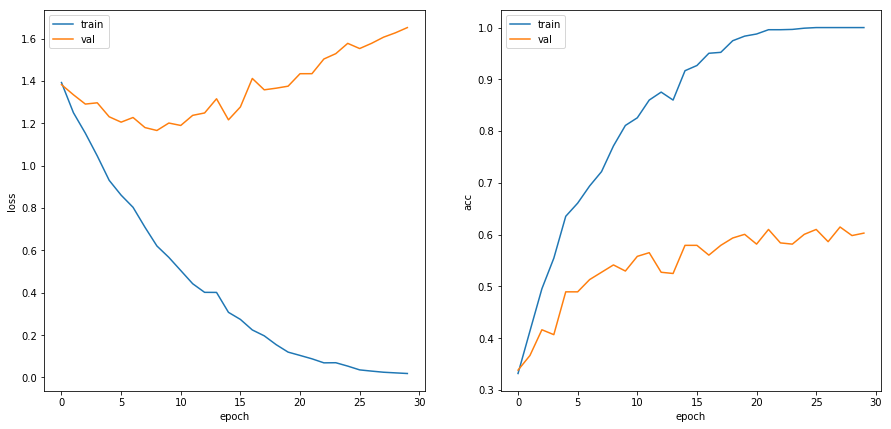

In [14]:
hist = shallow_model_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 2: shallow model with normilized data.

In this experiment we shaow that data normalization does not help to improve validation accuracy. For the following experiment with shallow model, we do not try to normilize data.

### Prepare data

In [15]:
# normilize the data USING ONLY TRAIN DATA MEAN AND STANDARD DEVIATION
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
X_valid_norm = (X_valid - np.mean(X_train))/np.std(X_train)
X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)

### Construct model

In [16]:
shallow_model_1000_norm = construct_shallow_model(1000)
shallow_model_1000_norm.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

### Make checkpoints

In [17]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_1000_norm',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

### Train model

In [19]:
shallow_model_1000_norm.fit(X_train_norm, y_train,
                            validation_data = (X_valid_norm, y_valid),
                            epochs = 30,
                            callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.9727 - acc: 0.2686
Epoch 00001: val_loss improved from inf to 1.46535, saving model to ./model_checkpoints/shallow_model_1000_norm
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_1000_norm/assets
1692/1692 [==============================] - 43s 25ms/sample - loss: 1.9629 - acc: 0.2701 - val_loss: 1.4654 - val_acc: 0.2955
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.3639 - acc: 0.3558
Epoch 00002: val_loss improved from 1.46535 to 1.39377, saving model to ./model_checkpoints/shallow_model_1000_norm
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_1000_norm/assets
1692/1692 [==============================] - 44s 26ms/sample - loss: 1.3610 - acc: 0.3582 - val_loss: 1.3938 - val_acc: 0.3428
Epoch 3/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.3326 - acc: 0.3810
Epoch 00003: val_los

Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.4566 - acc: 0.8474
Epoch 00026: val_loss did not improve from 1.17352
1692/1692 [==============================] - 45s 27ms/sample - loss: 0.4588 - acc: 0.8469 - val_loss: 1.1824 - val_acc: 0.5603
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.4398 - acc: 0.8630
Epoch 00027: val_loss did not improve from 1.17352
1692/1692 [==============================] - 46s 27ms/sample - loss: 0.4372 - acc: 0.8641 - val_loss: 1.2285 - val_acc: 0.5674
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.3981 - acc: 0.8768
Epoch 00028: val_loss did not improve from 1.17352
1692/1692 [==============================] - 46s 27ms/sample - loss: 0.4016 - acc: 0.8753 - val_loss: 1.2245 - val_acc: 0.5650
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.3846 - acc: 0.8798
Epoch 00029: val_loss did not improve from 1.17352
1692/1692 [============================

# Experiment 3: shallow model - accuracy vs number of timestamps 

In this experiment we show that accuracy peaks at 700 timestamps per sample

### Train models

In [20]:
TIME_WINDOW = 300
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_300 = construct_shallow_model(TIME_WINDOW)
shallow_model_300.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_300.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 300)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 300)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.5962 - acc: 0.3071
Epoch 00001: val_loss improved from inf to 1.39737, saving model to ./model_checkpoints/shallow_model_300
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_300/assets
1692/1692 [==============================] - 15s 9ms/sample - loss: 1.5955 - acc: 0.3061 - val_loss: 1.3974 - val_acc: 0.3239
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.3132 - acc: 0.3744
Epoch 00002: val_loss improved from 1.39737 to 1.31302, saving model to ./model_checkpoints/shallow_model_300
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_300/assets
1692/1692 [==============================] - 15s 9ms/sample - loss: 1.3122 - acc: 0

Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.2909 - acc: 0.9183
Epoch 00026: val_loss did not improve from 1.09863
1692/1692 [==============================] - 12s 7ms/sample - loss: 0.2943 - acc: 0.9161 - val_loss: 1.3608 - val_acc: 0.5343
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.2550 - acc: 0.9345
Epoch 00027: val_loss did not improve from 1.09863
1692/1692 [==============================] - 13s 8ms/sample - loss: 0.2533 - acc: 0.9350 - val_loss: 1.6543 - val_acc: 0.4823
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.2311 - acc: 0.9369
Epoch 00028: val_loss did not improve from 1.09863
1692/1692 [==============================] - 12s 7ms/sample - loss: 0.2344 - acc: 0.9350 - val_loss: 1.4228 - val_acc: 0.5319
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1953 - acc: 0.9519
Epoch 00029: val_loss did not improve from 1.09863
1692/1692 [==============================]

In [21]:
TIME_WINDOW = 500
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_500 = construct_shallow_model(TIME_WINDOW)
shallow_model_500.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_500.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 500)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 500)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.6511 - acc: 0.3149
Epoch 00001: val_loss improved from inf to 1.35016, saving model to ./model_checkpoints/shallow_model_500
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_500/assets
1692/1692 [==============================] - 26s 15ms/sample - loss: 1.6480 - acc: 0.3150 - val_loss: 1.3502 - val_acc: 0.3712
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2611 - acc: 0.4177
Epoch 00002: val_loss improved from 1.35016 to 1.28976, saving model to ./model_checkpoints/shallow_model_500
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_500/assets
1692/1692 [==============================] - 21s 13ms/sample - loss: 1.2620 - acc:

1664/1692 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9880
Epoch 00025: val_loss did not improve from 0.97089
1692/1692 [==============================] - 23s 14ms/sample - loss: 0.0997 - acc: 0.9882 - val_loss: 1.1814 - val_acc: 0.6525
Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9946
Epoch 00026: val_loss did not improve from 0.97089
1692/1692 [==============================] - 23s 13ms/sample - loss: 0.0851 - acc: 0.9941 - val_loss: 1.2083 - val_acc: 0.6856
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9970
Epoch 00027: val_loss did not improve from 0.97089
1692/1692 [==============================] - 23s 14ms/sample - loss: 0.0638 - acc: 0.9970 - val_loss: 1.2502 - val_acc: 0.6667
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 1.0000
Epoch 00028: val_loss did not improve from 0.97089
1692/1692 [==============================] - 23s 14

In [22]:
TIME_WINDOW = 600
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_600 = construct_shallow_model(TIME_WINDOW)
shallow_model_600.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_600.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 600)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 600)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.6810 - acc: 0.3095
Epoch 00001: val_loss improved from inf to 1.35520, saving model to ./model_checkpoints/shallow_model_600
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_600/assets
1692/1692 [==============================] - 26s 15ms/sample - loss: 1.6761 - acc: 0.3073 - val_loss: 1.3552 - val_acc: 0.3404
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2589 - acc: 0.4267
Epoch 00002: val_loss improved from 1.35520 to 1.31261, saving model to ./model_checkpoints/shallow_model_600
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_600/assets
1692/1692 [==============================] - 29s 17ms/sample - loss: 1.2605 - acc:

Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9826
Epoch 00026: val_loss did not improve from 0.97224
1692/1692 [==============================] - 26s 16ms/sample - loss: 0.1106 - acc: 0.9829 - val_loss: 1.2188 - val_acc: 0.6217
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0962 - acc: 0.9892
Epoch 00027: val_loss did not improve from 0.97224
1692/1692 [==============================] - 28s 16ms/sample - loss: 0.0959 - acc: 0.9894 - val_loss: 1.2209 - val_acc: 0.6501
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0916 - acc: 0.9880
Epoch 00028: val_loss did not improve from 0.97224
1692/1692 [==============================] - 32s 19ms/sample - loss: 0.0916 - acc: 0.9882 - val_loss: 1.2423 - val_acc: 0.6241
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9856
Epoch 00029: val_loss did not improve from 0.97224
1692/1692 [============================

In [23]:
TIME_WINDOW = 700
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_700 = construct_shallow_model(TIME_WINDOW)
shallow_model_700.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_700.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 700)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 700)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.7667 - acc: 0.2951
Epoch 00001: val_loss improved from inf to 1.38685, saving model to ./model_checkpoints/shallow_model_700
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_700/assets
1692/1692 [==============================] - 42s 25ms/sample - loss: 1.7625 - acc: 0.2943 - val_loss: 1.3868 - val_acc: 0.3144
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2869 - acc: 0.3924
Epoch 00002: val_loss improved from 1.38685 to 1.32235, saving model to ./model_checkpoints/shallow_model_700
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_700/assets
1692/1692 [==============================] - 40s 24ms/sample - loss: 1.2903 - acc:

1664/1692 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9754
Epoch 00025: val_loss did not improve from 0.98868
1692/1692 [==============================] - 33s 19ms/sample - loss: 0.1332 - acc: 0.9746 - val_loss: 1.1919 - val_acc: 0.6619
Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9790
Epoch 00026: val_loss did not improve from 0.98868
1692/1692 [==============================] - 33s 20ms/sample - loss: 0.1182 - acc: 0.9793 - val_loss: 1.2270 - val_acc: 0.6217
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9748
Epoch 00027: val_loss did not improve from 0.98868
1692/1692 [==============================] - 37s 22ms/sample - loss: 0.1217 - acc: 0.9752 - val_loss: 1.2960 - val_acc: 0.6288
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0836 - acc: 0.9904
Epoch 00028: val_loss did not improve from 0.98868
1692/1692 [==============================] - 32s 19

In [24]:
TIME_WINDOW = 800
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_800 = construct_shallow_model(TIME_WINDOW)
shallow_model_800.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_800.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 800)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 800)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.8781 - acc: 0.3077
Epoch 00001: val_loss improved from inf to 1.40559, saving model to ./model_checkpoints/shallow_model_800
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_800/assets
1692/1692 [==============================] - 38s 23ms/sample - loss: 1.8691 - acc: 0.3073 - val_loss: 1.4056 - val_acc: 0.3381
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2894 - acc: 0.4002
Epoch 00002: val_loss did not improve from 1.40559
1692/1692 [==============================] - 34s 20ms/sample - loss: 1.2850 - acc: 0.4019 - val_loss: 1.4072 - val_acc: 0.3783
Epoch 3/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.1747 - acc: 0.4928
E

1664/1692 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9952
Epoch 00026: val_loss did not improve from 1.08127
1692/1692 [==============================] - 35s 21ms/sample - loss: 0.0577 - acc: 0.9953 - val_loss: 1.4056 - val_acc: 0.6265
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 1.0000
Epoch 00027: val_loss did not improve from 1.08127
1692/1692 [==============================] - 35s 20ms/sample - loss: 0.0439 - acc: 1.0000 - val_loss: 1.4711 - val_acc: 0.6028
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 1.0000
Epoch 00028: val_loss did not improve from 1.08127
1692/1692 [==============================] - 36s 22ms/sample - loss: 0.0363 - acc: 1.0000 - val_loss: 1.4720 - val_acc: 0.5981
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 1.0000
Epoch 00029: val_loss did not improve from 1.08127
1692/1692 [==============================] - 36s 21

In [25]:
TIME_WINDOW = 900
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_900 = construct_shallow_model(TIME_WINDOW)
shallow_model_900.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_900.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 900)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 900)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.8942 - acc: 0.2879
Epoch 00001: val_loss improved from inf to 1.38605, saving model to ./model_checkpoints/shallow_model_900
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_900/assets
1692/1692 [==============================] - 41s 24ms/sample - loss: 1.8866 - acc: 0.2884 - val_loss: 1.3860 - val_acc: 0.3570
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2639 - acc: 0.4201
Epoch 00002: val_loss improved from 1.38605 to 1.32799, saving model to ./model_checkpoints/shallow_model_900
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_900/assets
1692/1692 [==============================] - 42s 25ms/sample - loss: 1.2656 - acc:

Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9994
Epoch 00027: val_loss did not improve from 1.08576
1692/1692 [==============================] - 40s 24ms/sample - loss: 0.0498 - acc: 0.9994 - val_loss: 1.5012 - val_acc: 0.5957
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9994
Epoch 00028: val_loss did not improve from 1.08576
1692/1692 [==============================] - 40s 24ms/sample - loss: 0.0412 - acc: 0.9994 - val_loss: 1.5195 - val_acc: 0.5863
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 1.0000
Epoch 00029: val_loss did not improve from 1.08576
1692/1692 [==============================] - 40s 24ms/sample - loss: 0.0285 - acc: 1.0000 - val_loss: 1.5090 - val_acc: 0.5981
Epoch 30/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 1.0000
Epoch 00030: val_loss did not improve from 1.08576
1692/1692 [============================

In [26]:
best_shallow_model_300 = keras.models.load_model('./model_checkpoints/shallow_model_300')
best_shallow_model_500 = keras.models.load_model('./model_checkpoints/shallow_model_500')
best_shallow_model_600 = keras.models.load_model('./model_checkpoints/shallow_model_600')
best_shallow_model_700 = keras.models.load_model('./model_checkpoints/shallow_model_700')
best_shallow_model_800 = keras.models.load_model('./model_checkpoints/shallow_model_800')
best_shallow_model_900 = keras.models.load_model('./model_checkpoints/shallow_model_900')
best_shallow_model_1000 = keras.models.load_model('./model_checkpoints/shallow_model_1000')

number_of_samples = [300, 500, 600, 700, 800, 900, 1000]
accuracies = []


# ==================================== 300 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=300, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_300.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 500 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=500, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_500.evaluate(X_valid_slices, y_valid_slices)[1])



# ==================================== 600 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=600, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_600.evaluate(X_valid_slices, y_valid_slices)[1])



# ==================================== 700 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=700, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_700.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 800 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=800, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_800.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 900 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=900, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_900.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 1000 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=1000, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_1000.evaluate(X_valid_slices, y_valid_slices)[1])


423/423 [==============================] - 4s 9ms/sample - loss: 1.1665 - acc: 0.5414


# Plot the results

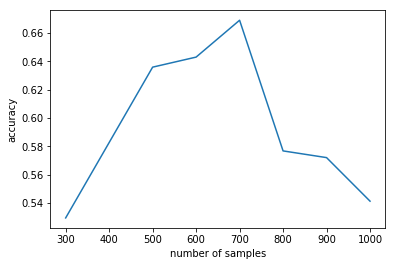

In [27]:
fig = plt.figure()
ax = plt.axes()

plt.xlabel('number of samples')
plt.ylabel('accuracy')
ax.plot(number_of_samples, accuracies);


# Results

In [28]:
X_test_slices, y_test_slices = sliding_window(X_test, 
                                              y_test, 
                                              time_window=700, 
                                              time_stride=TIME_STRIDE)

shallow_model_results = best_shallow_model_700.evaluate(X_test_slices, y_test_slices)


print('\n# Evaluate on test data')
print('Optimal shallow model test loss:', shallow_model_results[0])
print('Optimal shallow model test acc:', shallow_model_results[1])

443/443 [==============================] - 2s 5ms/sample - loss: 1.0659 - acc: 0.6208

# Evaluate on test data
Optimal shallow model test loss: 1.0659487419688136
Optimal shallow model test acc: 0.6207675
